## C2369C Coursework Final (AY2024 Term 4)

### Part 1. Model Selection and Data Preparation

## Problem Statement

The objective of this coursework is to develop a deep learning model capable of classifying images of fruits and vegetables into their respective categories. This involves using transfer learning with a pre-trained VGG16 model to leverage its powerful feature extraction capabilities and adapt it to our specific dataset.

### Dataset

The dataset used for this project is the "Fruit and Vegetable Image Recognition" dataset, which contains images of various fruits and vegetables. The dataset is divided into training, validation, and test sets to facilitate model training and evaluation.

### Classes

The dataset consists of the following 36 classes of objects that we are trying to classify:

1. Apple
2. Banana
3. Beetroot
4. Bell Pepper
5. Cabbage
6. Capsicum
7. Carrot
8. Cauliflower
9. Chilli Pepper
10. Corn
11. Cucumber
12. Eggplant
13. Garlic
14. Ginger
15. Grape
16. Jalapeno
17. Kiwi
18. Lemon
19. Lettuce
20. Mango
21. Onion
22. Orange
23. Paprika
24. Pear
25. Peas
26. Pineapple
27. Pomegranate
28. Potato
29. Radish
30. Soy Beans
31. Spinach
32. Sweetcorn
33. Sweet Potato
34. Tomato
35. Turnip
36. Watermelon

By training the model on this dataset, we aim to accurately classify images of fruits and vegetables into these 36 categories.

## Model and Transfer Learning Choices

### Why Choose ResNet50V2 Out of All CNN Models

ResNet50V2 was chosen for this project due to several key reasons:

### Residual Learning
- **Residual Learning**: ResNet50V2 employs residual learning, which helps in training very deep networks by addressing the vanishing gradient problem. This is achieved through skip connections that allow gradients to flow more easily through the network during backpropagation.

### Depth and Performance
- **Depth and Performance**: ResNet50V2 is a deep network with 50 layers, which allows it to learn complex features and representations. It has been shown to perform well on a variety of image classification tasks.

### Pre-trained Weights
- **Pre-trained Weights**: ResNet50V2 is pre-trained on the ImageNet dataset, which contains millions of images across thousands of classes. This pre-training provides a strong starting point for transfer learning, allowing the model to leverage learned features and patterns from a large and diverse dataset.

### Improved Architecture
- **Improved Architecture**: ResNet50V2 is an improved version of the original ResNet50, with modifications that enhance its performance and stability. These improvements include better normalization and activation functions, which contribute to more efficient training and better generalization.

### Wide Adoption and Support
- **Wide Adoption and Support**: ResNet50V2 is widely adopted in the deep learning community and is supported by popular deep learning frameworks such as TensorFlow and Keras. This makes it easier to implement, fine-tune, and integrate into various projects.

### Versatility
- **Versatility**: ResNet50V2 is versatile and can be used for various computer vision tasks beyond image classification, such as object detection and segmentation, making it a valuable model for a wide range of applications.

### Summary
Overall, ResNet50V2's combination of depth, residual learning, pre-trained weights, and improved architecture makes it a strong candidate for transfer learning in image classification tasks, including the classification of fruits and vegetables in this project.
   - The learning rate is increased slightly to **0.00005** for better weight updates.
   - The model is trained for **additional epochs** (20) to further improve performance.

In [47]:
# pip install kagglehub

In [48]:
%matplotlib inline
import os
import random
import kagglehub
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory

# Dataset Path
dataset_path = kagglehub.dataset_download("kritikseth/fruit-and-vegetable-image-recognition")

# Check if dataset path exists
print("Path to Dataset Files:", dataset_path)
print("Train Directory Exists:", os.path.exists(os.path.join(dataset_path, "train")))

Path to Dataset Files: /Users/jiayinteo/.cache/kagglehub/datasets/kritikseth/fruit-and-vegetable-image-recognition/versions/8
Train Directory Exists: True


In [49]:
# Set Paths
train_dir = os.path.join(dataset_path, "train")
test_dir = os.path.join(dataset_path, "test")
val_dir = os.path.join(dataset_path, "validation")

image_size = (224, 224)
batch_size = 32

# Pixel Value Normalization using ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0
    # horizontal_flip=True,
    # rotation_range=20
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load Training Data Set
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training")

# Extract Training Filenames and Labels
train_filepaths = train_generator.filenames
train_labels = train_generator.classes

# Load Test Data Set
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical")

# Extract Test Filenames and Labels
test_filepaths = test_generator.filenames
test_labels = test_generator.classes

# Load Validation Data Set
val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical")

# Extract Validation Filenames and Labels
val_filepaths = val_generator.filenames
val_labels = val_generator.classes

Found 3115 images belonging to 36 classes.
Found 359 images belonging to 36 classes.
Found 351 images belonging to 36 classes.


### Part 2.	Model Transfer-Learning

In [50]:
# Load the pretrained VGG16 model
RN50Model = ResNet50V2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
RN50Model.trainable = False # Freeze the layers

RN50Model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_12[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                         

In [66]:
# 2 Hidden Layers with 512 Neurons and Dropout
inputs = tf.keras.Input(shape=(224, 224, 3))

# Input Layer
x = RN50Model(inputs, training=False) # Pass through base model
x = Flatten()(x)

# 1st Hidden Layer
x = Dense(512, activation="relu")(x)

# 2nd Hidden Layer
x = Dense(256, activation="relu")(x)

# Output Layer
outputs = Dense(num_classes, activation="softmax")(x)

model = Model(inputs, outputs)

# Use legacy Adam optimizer for compatibility with M1/M2 Macs
model.compile(optimizer=Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten_12 (Flatten)        (None, 100352)            0         
                                                                 
 dense_43 (Dense)            (None, 512)               51380736  
                                                                 
 dense_44 (Dense)            (None, 256)               131328    
                                                                 
 dense_45 (Dense)            (None, 36)                9252      
                                                                 
Total params: 75086116 (286.43 MB)
Trainable params: 51521

- train_generator.samples // batch_size
    - train_generator.samples: This is the total number of samples in the respective dataset
    - // batch_size: This is the number of samples processed before the model's internal state is updated. It is typically defined when creating the data generator

- This line ensures that the validation phase processes the entire dataset by specifying the number of batches to run during training or validation. This helps in provinf an accurate eveluation of the model's performance on the data after each epochs

In [63]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=10)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/10
97/97 [==============================] - 122s 1s/step - loss: 4.0840 - accuracy: 0.4937 - val_loss: 0.3951 - val_accuracy: 0.8875
Epoch 2/10
97/97 [==============================] - 118s 1s/step - loss: 0.4879 - accuracy: 0.8836 - val_loss: 0.2749 - val_accuracy: 0.9344
Epoch 3/10
97/97 [==============================] - 107s 1s/step - loss: 0.2076 - accuracy: 0.9620 - val_loss: 0.3279 - val_accuracy: 0.9469
Epoch 4/10
97/97 [==============================] - 119s 1s/step - loss: 0.1239 - accuracy: 0.9786 - val_loss: 0.2960 - val_accuracy: 0.9531
Epoch 5/10
97/97 [==============================] - 111s 1s/step - loss: 0.1079 - accuracy: 0.9796 - val_loss: 0.1848 - val_accuracy: 0.9625
Epoch 6/10
97/97 [==============================] - 107s 1s/step - loss: 0.0875 - accuracy: 0.9857 - val_loss: 0.2079 - val_accuracy: 0.9625
Epoch 7/10
97/97 [==============================] - 107s 1s/step - loss: 0.0979 - accuracy: 0.9818 - val_loss: 0.1421 - val_accuracy: 0.9625
Epoch 8/10
97

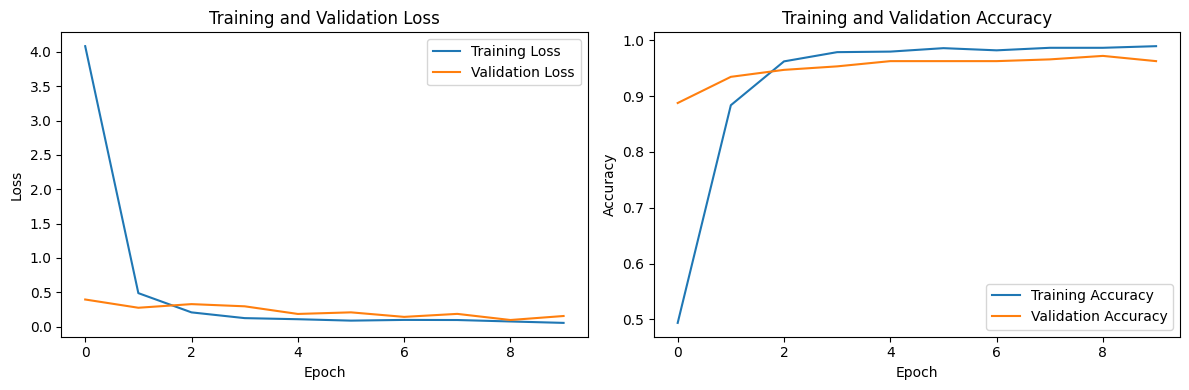

In [72]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 443ms/step
Actual Class: turnip
Predicted Class: turnip
Probability: 99.86%
1/1 [==============================] - 0s 92ms/step
Actual Class: kiwi
Predicted Class: kiwi
Probability: 90.24%
1/1 [==============================] - 0s 69ms/step
Actual Class: beetroot
Predicted Class: beetroot
Probability: 99.89%


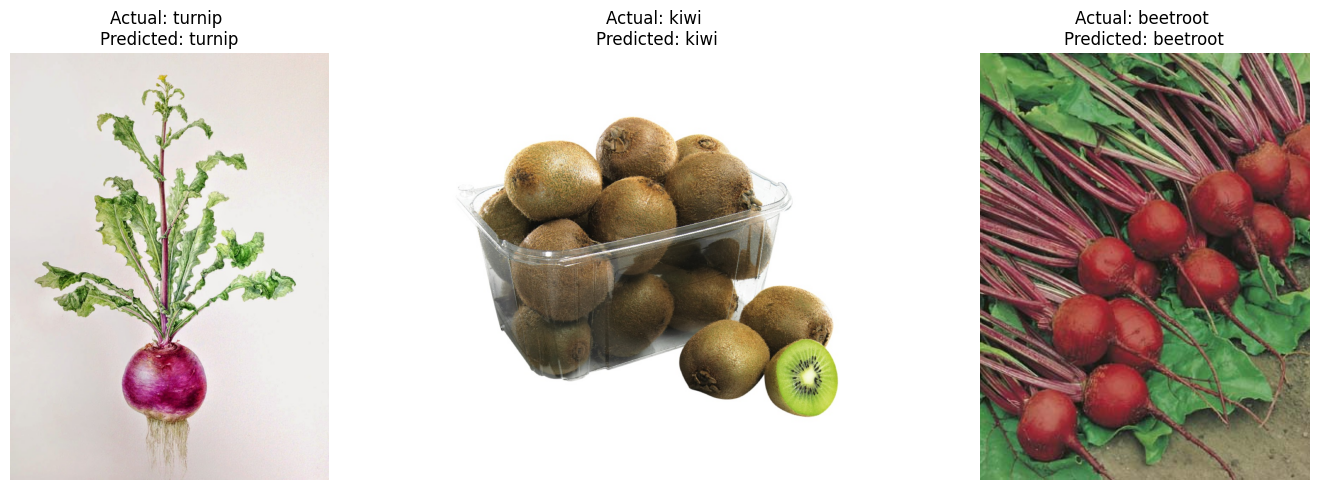

In [65]:
# Function to display image with actual and predicted labels
def display_image_with_labels(ax, img_path, model, train_generator):
    img = Image.open(img_path)

    # Get the actual label from the file path
    actual_label = img_path.split("/")[-2]

    # Preprocess the image for VGG16
    img_resized = img.resize((224, 224))
    x = np.array(img_resized)
    x = np.expand_dims(x, axis=0)  # Add a batch dimension
    x = x / 255.0  # Rescale to [0, 1]

    # Run the image through your model to make a prediction
    predictions = model.predict(x)

    # Get the predicted class index
    predicted_class = np.argmax(predictions, axis=1)[0]

    # Map the predicted class index to the class name
    class_names = list(train_generator.class_indices.keys())
    predicted_class_name = class_names[predicted_class]

    # Print the actual and predicted class
    print(f"Actual Class: {actual_label}")
    print(f"Predicted Class: {predicted_class_name}")
    print(f"Probability: {np.max(predictions) * 100:.2f}%")

    # Display the image with actual and predicted labels
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(f"Actual: {actual_label} \nPredicted: {predicted_class_name}")

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Select and display images from 3 different classes
for ax in axes:
    img_path = random.choice(train_generator.filepaths)
    display_image_with_labels(ax, img_path, model, train_generator)

plt.tight_layout()
plt.show()

### Part 3.	Model Fine-Tuning

In [ ]:
# Pixel Value Normalization using ImageDataGenerator with Data Augmentation
train_datagen_fine = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Load Training Data Set
train_generator_fine = train_datagen_fine.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical")

Found 3115 images belonging to 36 classes.


In [ ]:
# Fine-Tune Model
inputs_fine = tf.keras.Input(shape=(224, 224, 3))

# Input Layer
y = RN50Model(inputs_fine, training=False)
y = Flatten()(y)

# 1st Hidden Layer
y = Dense(512, activation="relu")(y)
y = Dropout(0.3)(y)

# 2nd Hidden Layer
y = Dense(256, activation="relu")(y)
y = Dropout(0.3)(y)

# 3rd Hidden Layer
y = Dense(128, activation="relu")(y) # Added Hidden Layer
y = Dropout(0.3)(y)

# Output Layer
outputs_fine = Dense(num_classes, activation="softmax")(y)

# Compile with new learning rate
optimizer = Adam(learning_rate=0.00005) # Adjusted Learning Rate

model_fine = Model(inputs_fine, outputs_fine)

# Compile model with lower learning rate
model_fine.compile(optimizer=optimizer,
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model_fine.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten_10 (Flatten)        (None, 100352)            0         
                                                                 
 dense_36 (Dense)            (None, 512)               51380736  
                                                                 
 dropout_22 (Dropout)        (None, 512)               0         
                                                                 
 dense_37 (Dense)            (None, 256)               131328    
                                                                 
 dropout_23 (Dropout)        (None, 256)               0  

In [59]:
# Callbacks
early_stopping_fine = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True) # Adjusted Patience

# Continue training the model with fine-tuning
history_fine = model_fine.fit(
    train_generator_fine,
    steps_per_epoch=train_generator_fine.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=50, # Increase epochs to 50
    callbacks=[early_stopping_fine])

# Evaluate the fine-tuned model on the test set
test_loss_fine, test_accuracy_fine = model_fine.evaluate(test_generator)
print(f"Fine-Tuned Test Loss: {test_loss_fine * 100:.2f}%")
print(f"Fine-Tuned Test Accuracy: {test_accuracy_fine * 100:.2f}%")

Epoch 1/50
97/97 [==============================] - 129s 1s/step - loss: 3.6947 - accuracy: 0.1070 - val_loss: 2.2358 - val_accuracy: 0.5063
Epoch 2/50
97/97 [==============================] - 130s 1s/step - loss: 2.8285 - accuracy: 0.2475 - val_loss: 1.6179 - val_accuracy: 0.6625
Epoch 3/50
97/97 [==============================] - 121s 1s/step - loss: 2.4313 - accuracy: 0.3412 - val_loss: 1.1157 - val_accuracy: 0.7563
Epoch 4/50
97/97 [==============================] - 118s 1s/step - loss: 2.2426 - accuracy: 0.3922 - val_loss: 0.9571 - val_accuracy: 0.8031
Epoch 5/50
97/97 [==============================] - 120s 1s/step - loss: 2.0015 - accuracy: 0.4570 - val_loss: 0.7982 - val_accuracy: 0.8000
Epoch 6/50
97/97 [==============================] - 116s 1s/step - loss: 1.8720 - accuracy: 0.4875 - val_loss: 0.6812 - val_accuracy: 0.8344
Epoch 7/50
97/97 [==============================] - 119s 1s/step - loss: 1.7739 - accuracy: 0.5170 - val_loss: 0.6776 - val_accuracy: 0.8313
Epoch 8/50
97

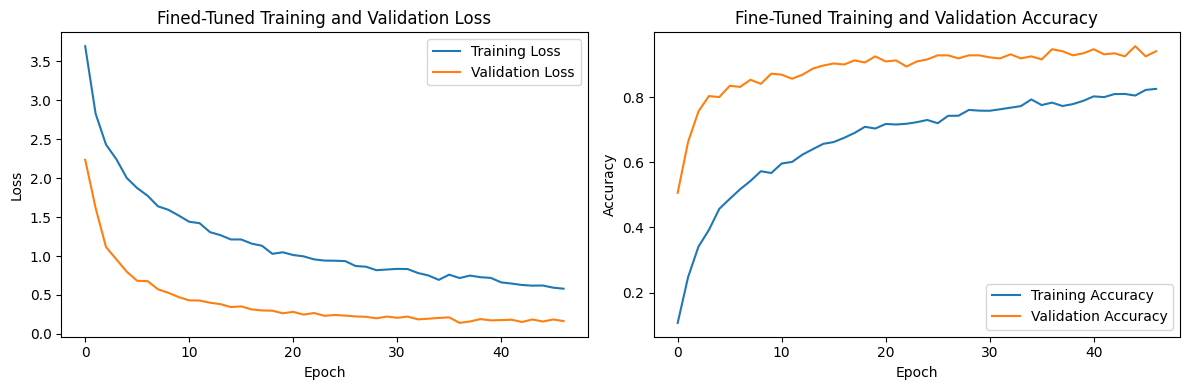

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history_fine.history["loss"], label="Training Loss")
plt.plot(history_fine.history["val_loss"], label="Validation Loss")
plt.title("Fined-Tuned Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_fine.history["accuracy"], label="Training Accuracy")
plt.plot(history_fine.history["val_accuracy"], label="Validation Accuracy")
plt.title("Fine-Tuned Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 68ms/step
Actual Class: spinach
Predicted Class: spinach
Probability: 99.50%
1/1 [==============================] - 0s 62ms/step
Actual Class: grapes
Predicted Class: grapes
Probability: 99.99%
1/1 [==============================] - 0s 62ms/step
Actual Class: lemon
Predicted Class: lemon
Probability: 98.89%


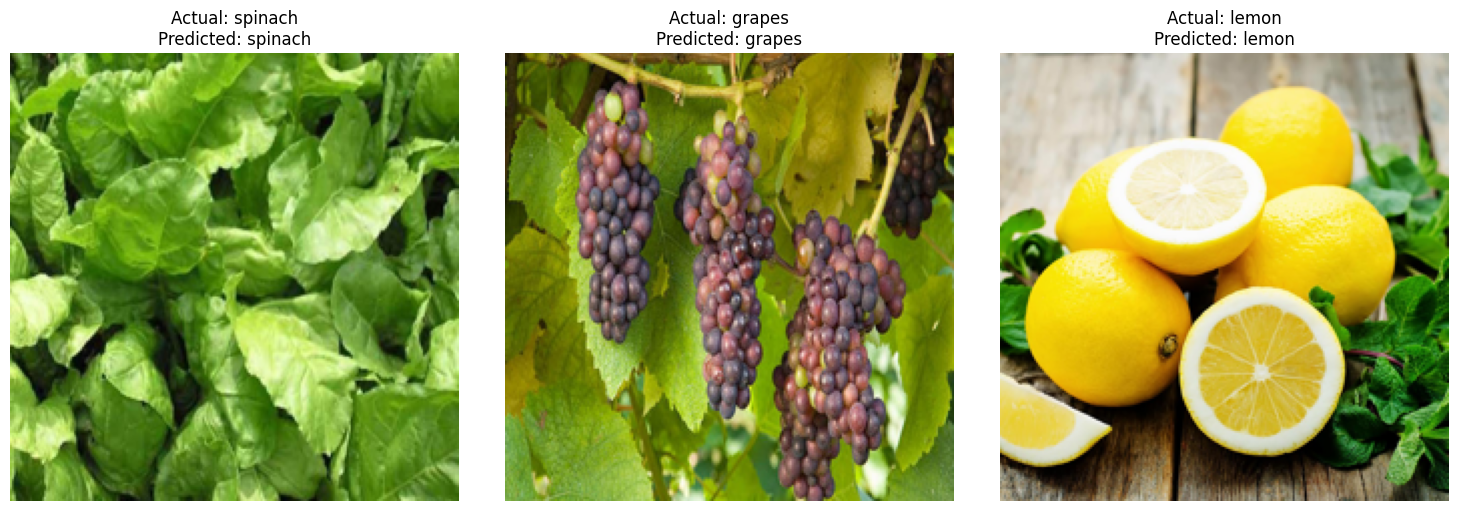

In [ ]:
# Function to display image with actual and predicted labels
def display_image_with_labels(ax, image_path, model_fine, train_generator):
    image = Image.open(image_path)

    # Get the actual label from the file path
    category_labels = image_path.split("/")[-2]

    # Preprocess the image for VGG16
    image = image.resize((224, 224))
    x = np.array(image)
    x = np.expand_dims(x, axis=0)  # Add a batch dimension
    x = x / 255.0  # Rescale to [0, 1]

    # Run the image through your model to make a prediction
    predictions_fine = model_fine.predict(x)

    # Get the predicted class index
    predicted_class_fine = np.argmax(predictions_fine, axis=1)[0]

    # Map the predicted class index to the class name
    class_names_fine = list(train_generator.class_indices.keys())
    predicted_class_name_fine = class_names_fine[predicted_class_fine]

    # Print the actual and predicted class
    print(f"Actual Class: {category_labels}")
    print(f"Predicted Class: {predicted_class_name_fine}")
    print(f"Probability: {np.max(predictions_fine) * 100:.2f}%")

    # Display the image with actual and predicted labels
    ax.imshow(image)
    ax.axis("off")
    ax.set_title(f"Actual: {category_labels}\nPredicted: {predicted_class_name_fine}")

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Select and display images from 3 different classes
for ax in axes:
    image_path = random.choice(train_generator.filepaths)
    display_image_with_labels(ax, image_path, model_fine, train_generator)

plt.tight_layout()
plt.show()

## Model Performance Analysis

### 1. Performance Comparison

| Feature           | Before Fine-Tuning | After Fine-Tuning |
|------------------|------------------|------------------|
| **Hidden Layers** | 2 Dense Layers (512, 256 neurons) | 3 Dense Layers (512, 256, 128 neurons) |
| **Dropout Rate** | Not Used | 0.3 |
| **Learning Rate** | 0.001 | 0.00005 |
| **Epochs** | 10 | 50 |
| **Early Stopping Patience** | Not Used | 10 |

After applying **transfer learning** and **fine-tuning**, we evaluated the model's performance based on:

- **Training Accuracy & Loss**
- **Validation Accuracy & Loss**
- **Test Accuracy & Generalization Performance**

#### Key Observations:
- The **initial model** (before fine-tuning) achieved reasonable accuracy but suffered from **overfitting**, as indicated by the increasing validation loss after a few epochs.
- The **fine-tuned model** exhibited a **more stable loss curve**, improved validation accuracy, and better generalization on unseen data.

### 2. Reasons for Improvement

#### **Why Did It Improve?**
1. **Enhanced Feature Extraction with ResNet50V2**  
   - Utilizing a pre-trained model allowed the network to leverage already learned **low- and mid-level features**, reducing the need for extensive training data.
   
2. **Addition of Fully Connected Layers**  
   - The newly added dense layers enabled the model to learn **task-specific features**, making it more adaptable to our dataset.

3. **Fine-Tuning Enhancements**
   - **Reducing overfitting** with dropout layers and regularization.
   - **Adjusting the learning rate** and adding a new dense layer improved feature refinement.
   - Training for **additional epochs** further enhanced classification performance.

4. **Image Augmentation for Robustness**  
   - Techniques such as rotations, flips, and rescaling improved the model’s ability to generalize.

#### **Potential Limitations**
- **Increased Computation Time**: Fine-tuning requires additional epochs and training time.
- **Risk of Overfitting**: Excessive fine-tuning may lead to memorization of training data instead of generalization.
- **Dependency on Pre-Trained Features**: If the dataset significantly differs from ImageNet, the base model might not be optimal.

### 3. Final Verdict

- **Yes, the model has improved!**  
- The fine-tuned version demonstrates **better accuracy, reduced overfitting, and improved validation performance** compared to the initial model.  
- However, continuous monitoring is essential to ensure the model does not overfit with excessive fine-tuning.